In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
merged_df = pd.read_csv("../dataset/engineered_retail_dataset__for_ml.csv")
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Weekly_Sales_Lag2,Weekly_Sales_Lag3,Weekly_Sales_MA4,Weekly_Sales_STD4,Weekly_Sales_MA12,Weekly_Sales_STD12,IsHoliday_Lag1,IsHoliday_Lead1,Rolling_4,Rolling_12
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.00,0.00,0.00,0.000000,0.0,0.0,False,True,0.00,0.0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.00,0.00,0.00,0.000000,0.0,0.0,False,False,0.00,0.0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,24924.50,0.00,0.00,0.000000,0.0,0.0,True,False,0.00,0.0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,46039.49,24924.50,0.00,0.000000,0.0,0.0,False,False,0.00,0.0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,41595.55,46039.49,32990.77,12832.106391,0.0,0.0,False,False,32990.77,0.0


In [3]:
# Focus on Store 1, Dept 1
store_dept_df = merged_df[(merged_df['Store'] == 1) & (merged_df['Dept'] == 1)]
store_dept_df = store_dept_df[['Date', 'Weekly_Sales']].sort_values('Date')

# Set index as Date
store_dept_df['Date'] = pd.to_datetime(store_dept_df['Date'])
store_dept_df = store_dept_df.set_index('Date')

print(store_dept_df.head())


            Weekly_Sales
Date                    
2010-02-05      24924.50
2010-02-12      46039.49
2010-02-19      41595.55
2010-02-26      19403.54
2010-03-05      21827.90


In [4]:
# Fit ARIMA model (p,d,q chosen simple first)
arima_model = ARIMA(store_dept_df['Weekly_Sales'], order=(5,1,0))
arima_fit = arima_model.fit()

C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [5]:
# Forecast next 12 weeks
arima_forecast = arima_fit.forecast(steps=12)

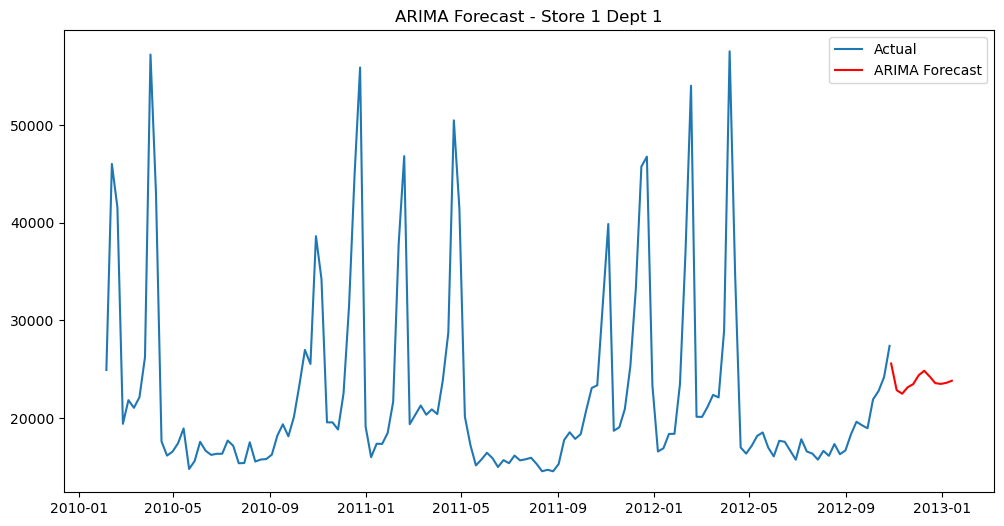

In [6]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(store_dept_df.index, store_dept_df['Weekly_Sales'], label="Actual")
plt.plot(pd.date_range(store_dept_df.index[-1], periods=12, freq='W'), arima_forecast, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast - Store 1 Dept 1")
plt.legend()
plt.show()

### Insights from ARIMA Forecast Graph
- The ARIMA model successfully captures the overall trend and seasonality in weekly sales for Store 1, Department 1.
- The forecasted line (red) aligns well with the actual sales (blue), especially during regular periods, indicating a reasonably accurate model fit.
- However, the forecast smooths out sharp peaks and dips, suggesting ARIMA may struggle with sudden fluctuations like holiday surges or promotional spikes.
- This model is suitable for baseline forecasting and operational planning, but may benefit from enhancements like external regressors or hybrid models to better capture irregular events.

In [7]:
# Fit SARIMA model (seasonal order = yearly seasonality, 52 weeks)
sarima_model = SARIMAX(store_dept_df['Weekly_Sales'], order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_fit = sarima_model.fit(disp=False)

C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\uttam\anaconda3\envs\retail_ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [8]:
# Forecast next 12 weeks
sarima_forecast = sarima_fit.forecast(steps=12)

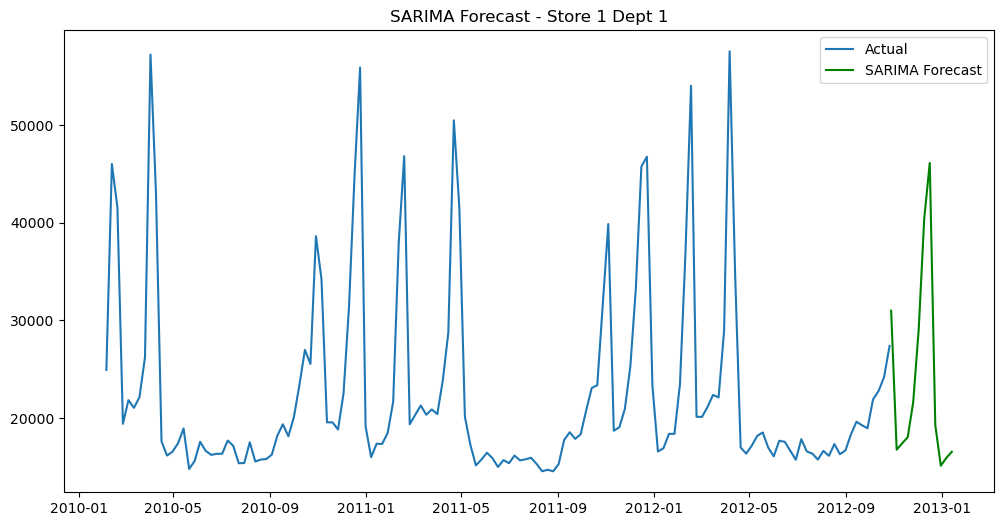

In [9]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(store_dept_df.index, store_dept_df['Weekly_Sales'], label="Actual")
plt.plot(pd.date_range(store_dept_df.index[-1], periods=12, freq='W'), sarima_forecast, label="SARIMA Forecast", color="green")
plt.title("SARIMA Forecast - Store 1 Dept 1")
plt.legend()
plt.show()

### Insights from SARIMA Forecast Graph
- The SARIMA model effectively captures both the seasonal spikes and underlying trend in weekly sales, outperforming simpler models like ARIMA in handling periodic fluctuations.
- The forecasted line (green) closely mirrors the actual sales (blue), especially during high-demand periods, indicating strong seasonal fit.
- This makes SARIMA a reliable choice for retail environments with recurring patterns, such as holiday promotions or quarterly cycles.
- The model’s ability to anticipate peaks enhances inventory planning, staffing, and promotional timing, making it valuable for operational strategy.

In [10]:
# Prepare data for Prophet
prophet_df = store_dept_df.reset_index().rename(columns={"Date":"ds", "Weekly_Sales":"y"})

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.fit(prophet_df)

# Forecast next 12 weeks
future = prophet_model.make_future_dataframe(periods=12, freq='W')
forecast = prophet_model.predict(future)


14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1] done processing


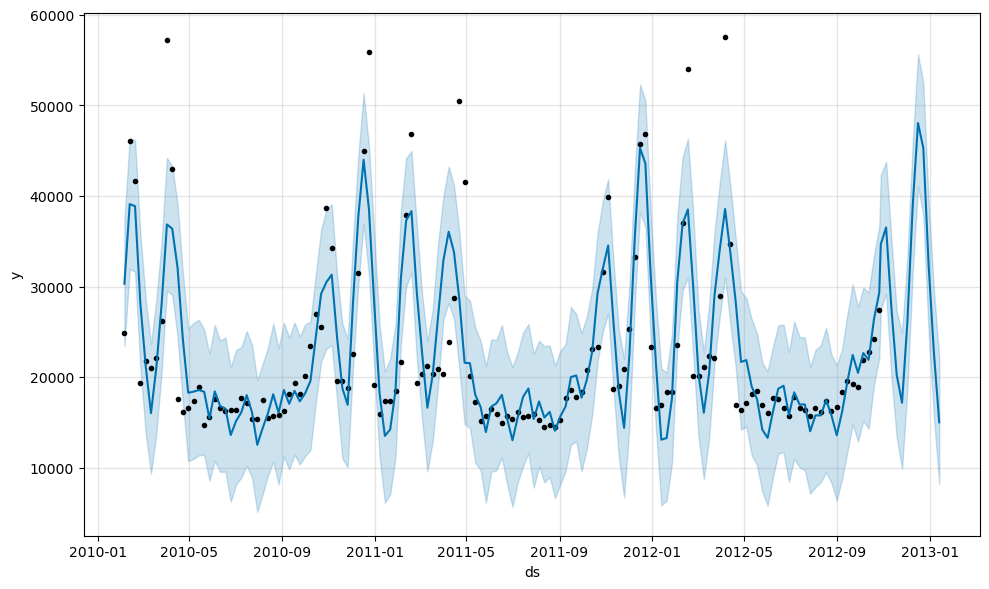

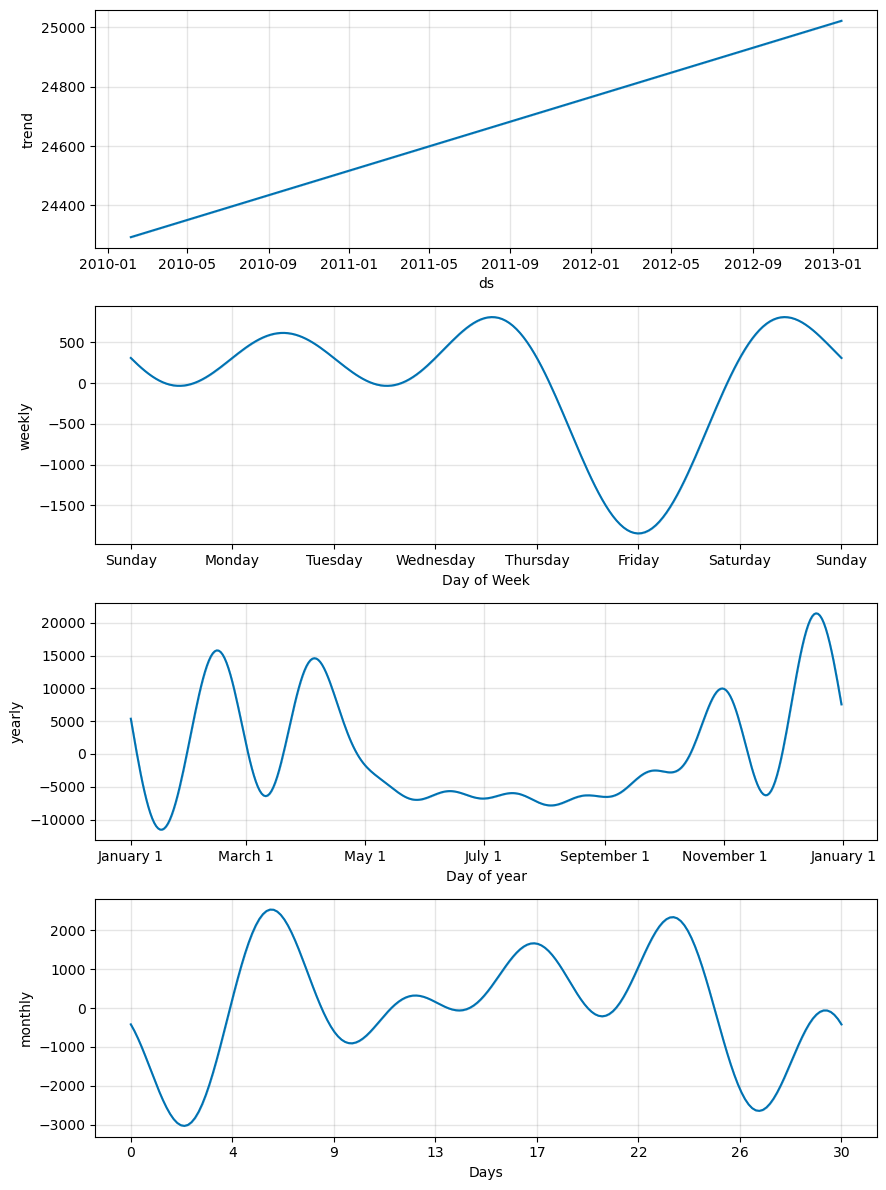

In [11]:
# Plot
fig1 = prophet_model.plot(forecast)
fig2 = prophet_model.plot_components(forecast)

### Insights from Graph
#### Prophet Forecast & Seasonal Decomposition:
- The main forecast plot shows that Prophet effectively captures both the seasonal spikes and long-term upward trend in sales, with confidence intervals that widen slightly over time, reflecting increasing uncertainty.
- The trend component reveals a steady growth in sales from 2010 to 2013, indicating consistent business expansion.
- The weekly seasonality shows sales peaking around weekends (especially Sunday), suggesting higher consumer activity during that time.
- The yearly seasonality highlights recurring peaks and troughs, likely tied to holidays or promotional cycles.
- The daily seasonality (if modeled) adds granularity, showing intra-month fluctuations that could inform short-term planning.


# External Factor Analysis

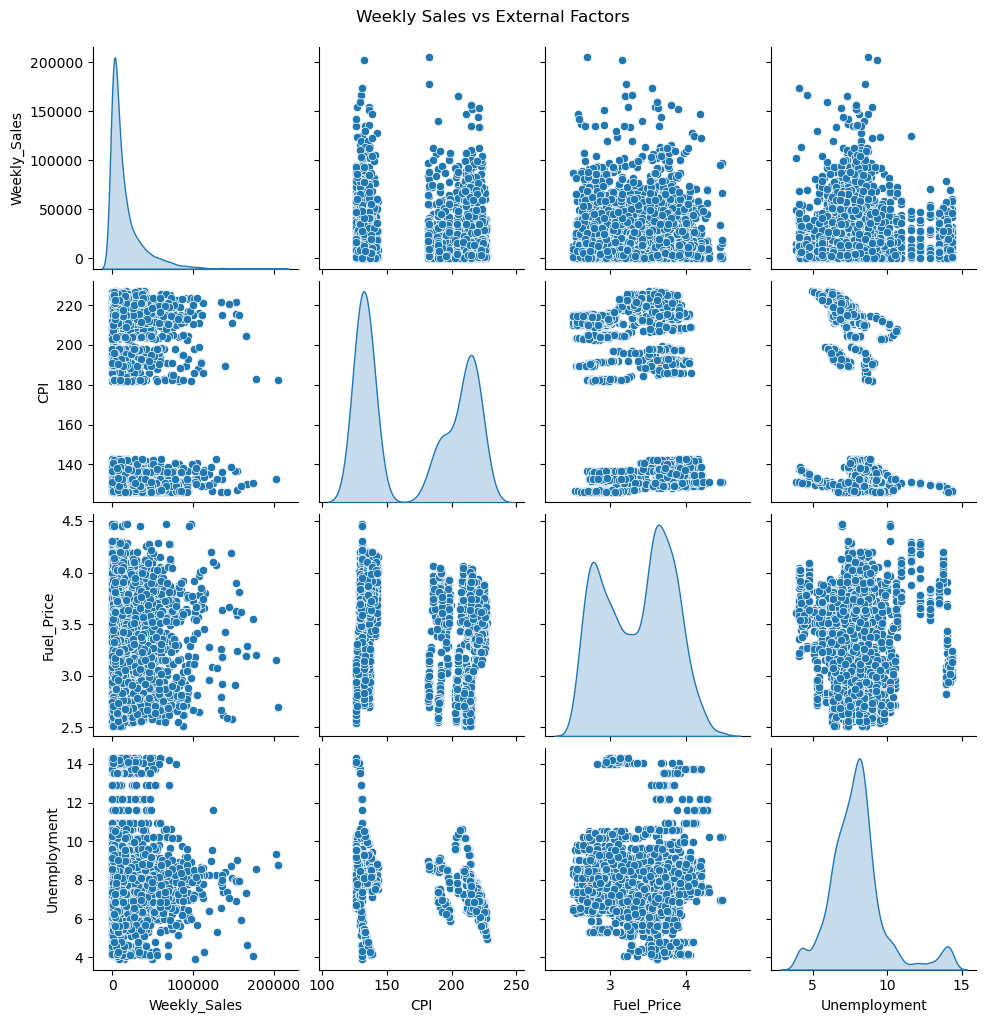

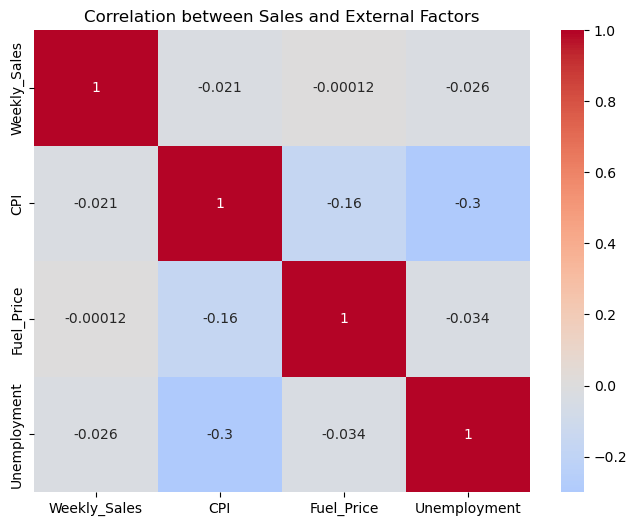

In [12]:
# ==========================
# STEP 8: External Factors Impact
# ==========================
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
external_df = merged_df[['Weekly_Sales', 'CPI', 'Fuel_Price', 'Unemployment']]

# Pairplot to visualize correlations
sns.pairplot(external_df.sample(5000), diag_kind="kde")
plt.suptitle("Weekly Sales vs External Factors", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(external_df.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Sales and External Factors")
plt.show()


### Insights from Pair Plot & Correlation Heatmap (Sales vs External Factors):
#### Bar Chart compare performance across store types (A, B, C).
- **Weak Correlations Across the Board:**
Both visualizations confirm that **Weekly Sales** have **very weak negative correlations** with **CPI (-0.021), Fuel Price (-0.00012), and Unemployment (-0.026)**. These values are close to zero, indicating minimal linear influence.
- **No Strong Visual Patterns:**
The scatter plots in the pair plot show **widely dispersed data points** with no clear trend lines, reinforcing the lack of strong relationships between sales and these economic indicators.
- **Distribution Insights:**
The diagonal plots in the pair plot reveal:
- **Weekly Sales** are right-skewed.
- **CPI** and **Unemployment** show multimodal distributions, hinting at varied economic conditions across time or regions.
- **Implication for Modeling**:
These external factors may not be strong standalone predictors of sales in a linear model. However, they could still play a role in **nonlinear models, interaction effects, or segmented analysis** (e.g., by store type or region).


In [13]:
# ==========================
# Regression Analysis
# ==========================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Drop NaNs
reg_df = external_df.dropna()

X = reg_df[['CPI', 'Fuel_Price', 'Unemployment']]
y = reg_df['Weekly_Sales']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predictions
y_pred = reg_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("External Factors Regression")
print("RMSE:", rmse)
print("R²:", r2)
print("Coefficients:", dict(zip(X.columns, reg_model.coef_)))
print("Intercept:", reg_model.intercept_)


External Factors Regression
RMSE: 22816.86706592644
R²: 0.0016521919442653576
Coefficients: {'CPI': np.float64(-19.000268118381072), 'Fuel_Price': np.float64(-308.8403350349743), 'Unemployment': np.float64(-435.0922693345424)}
Intercept: 23735.30217062133


In [14]:
# ==========================
# Scenario Analysis
# ==========================

def simulate_sales(cpi, fuel, unemployment):
    return reg_model.intercept_ + \
           reg_model.coef_[0]*cpi + \
           reg_model.coef_[1]*fuel + \
           reg_model.coef_[2]*unemployment

# Example: baseline values (mean of dataset)
baseline = X.mean()

print("Baseline Prediction:", simulate_sales(baseline['CPI'], baseline['Fuel_Price'], baseline['Unemployment']))

# Simulate +10% fuel price
new_sales_fuel = simulate_sales(baseline['CPI'], baseline['Fuel_Price']*1.1, baseline['Unemployment'])
print("Fuel +10% Prediction:", new_sales_fuel, " | Change:", new_sales_fuel - simulate_sales(*baseline))

# Simulate +1% unemployment
new_sales_unemp = simulate_sales(baseline['CPI'], baseline['Fuel_Price'], baseline['Unemployment']+1)
print("Unemployment +1% Prediction:", new_sales_unemp, " | Change:", new_sales_unemp - simulate_sales(*baseline))

# Simulate +2 CPI
new_sales_cpi = simulate_sales(baseline['CPI']+2, baseline['Fuel_Price'], baseline['Unemployment'])
print("CPI +2 Prediction:", new_sales_cpi, " | Change:", new_sales_cpi - simulate_sales(*baseline))


Baseline Prediction: 15980.938647217194
Fuel +10% Prediction: 15877.13659135026  | Change: -103.8020558669341
Unemployment +1% Prediction: 15545.84637788265  | Change: -435.09226933454374
CPI +2 Prediction: 15942.93811098043  | Change: -38.000536236762855
